|| SPAM DETECTION ||
By: Alind Singh (R00224088)

In [67]:
import os
import shutil
from sklearn.model_selection import train_test_split

#Set the path to Enron dataset
enron_data_dir = 'email_dataset'   #As the dataset directory and the jupyter notebook are in the same folder

#Create the directories to store the training and test data
train_set_dir = os.path.join(enron_data_dir,'train')
test_set_dir = os.path.join(enron_data_dir,'test')
if(os.path.isdir(train_set_dir)): 
    shutil.rmtree(train_set_dir)   #Remove the training directory if it exists, in order to make sure that 
                                   #contents aren't added to existing data that will disrupt the 70:30 split ratio 
if(os.path.isdir(test_set_dir)):
    shutil.rmtree(test_set_dir)    #Remove the test directory if it exists, in order to make sure that 
                                   #contents aren't added to existing data that will disrupt the 70:30 split ratio

os.makedirs(train_set_dir)         #Make new empty training directory
os.makedirs(test_set_dir)          #Make new empty test directory

#Loop through each email in the dataset and assign it to a set
emails = set()   #Dealing with duplicate emails by using a set
for fname in os.listdir(enron_data_dir):
    if fname in test_set_dir:
        continue #Not reading the test directory that was created earlier
    elif fname in train_set_dir:
        continue #Not reading the training directory that was created earlier
    fpath = os.path.join(enron_data_dir,fname)
    if(os.stat(fpath).st_size == 0):
        continue #Ignoring empty files  
    emails.add(fname)       


#Split the emails into training and test sets (70:30 ratio)
train, test = train_test_split(list(emails),train_size=0.7)

#Assign emails to the training and test directories created earlier
for fname in train:
    source = os.path.join(enron_data_dir,fname)
    destination = os.path.join(train_set_dir,fname)
    shutil.copy(source,destination)

for fname in test:
    source = os.path.join(enron_data_dir,fname)
    destination = os.path.join(test_set_dir,fname)
    shutil.copy(source,destination) 

#Collect and record statistics on the resulting training and test sets
no_spam_in_train = 0    
no_legit_in_train = 0
no_spam_in_test = 0
no_legit_in_test = 0
for fname in os.listdir(train_set_dir):
    if fname.__contains__('.spam'):
        no_spam_in_train += 1
    else:
        no_legit_in_train +=1
for fname in os.listdir(test_set_dir):
    if fname.__contains__('.spam'):
        no_spam_in_test += 1
    else:
        no_legit_in_test +=1                
print(f"Training set: It has {no_spam_in_train} spam emails, {no_legit_in_train} legitimate emails.")
print(f"Test set: It has {no_spam_in_test} spam emails, {no_legit_in_test} legitimate emails.")

Training set: It has 1041 spam emails, 2579 legitimate emails.
Test set: It has 459 spam emails, 1093 legitimate emails.


Now after a near perfect 70:30 split of the dataset; we move towards feature extraction process.
We'll start with 'Bag-of-words' model in which the file contents are converted into a feature (i.e. Words) matrix. This may help us in classification by analysing the text of the email itself.

The model is used on the training set.

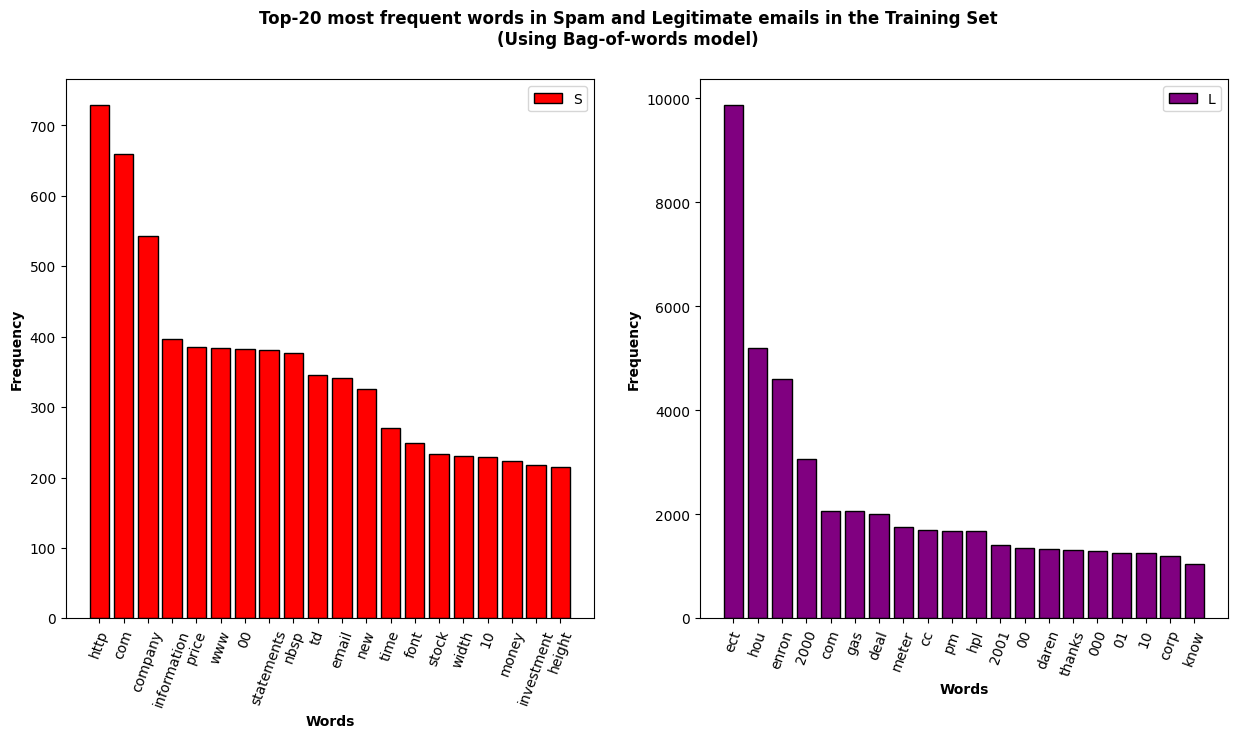

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Create two lists; each for spam and legitimate email's contents
spam_contents = []
legitimate_contents = []
for fname in os.listdir(train_set_dir):
    fpath = os.path.join(train_set_dir,fname)
    with open(fpath,'r',encoding='latin1') as f:
        content = f.read()  #Read the contents of each file
        if(fname.__contains__('.spam')):
            spam_contents.append(content)
        else:
            legitimate_contents.append(content)

#Create vectorizers for both spam and legitimate emails; restricting the resultant matrices to top 20 most frequent words in the corpus
spam_vectorizer = CountVectorizer(max_features=20,max_df=0.5,stop_words='english') #Stop-word removal, Ignoring common words that appear in more than 50% of documents 
legit_vectorizer = CountVectorizer(max_features=20,max_df=0.5,stop_words='english')

#Create feature matrices using both spam and legitimate email's content
spam_features = spam_vectorizer.fit_transform(raw_documents=spam_contents)
legit_features = legit_vectorizer.fit_transform(raw_documents=legitimate_contents)

#Convert the matrices into easily accessible arrays
spam_array = spam_features.toarray()
legit_array = legit_features.toarray()

#Access the words and their respective frequencies from the feature matrix
spam_words = spam_vectorizer.get_feature_names_out().tolist()
legit_words = legit_vectorizer.get_feature_names_out().tolist()
spam_words_frequency = np.sum(spam_array,axis=0)
legit_words_frequency = np.sum(legit_array,axis=0)

#Create dataframes for both spam and legitimate words with their respective frequencies in descending order
spam_df = pd.DataFrame({'word':spam_words,'frequency':spam_words_frequency}).sort_values(by='frequency',ascending=False)
legit_df = pd.DataFrame({'word':legit_words,'frequency':legit_words_frequency}).sort_values(by='frequency',ascending=False)

fig, axs = plt.subplots(1,2,figsize=(15,7))

#Create a bar plot for the spam words and set the plot details
axs[0].bar(spam_df['word'],spam_df['frequency'],color='red',edgecolor='black')
axs[0].set_xlabel('Words',fontweight='bold')
axs[0].set_ylabel('Frequency',fontweight='bold')
axs[0].tick_params(axis='x',rotation=70)
axs[0].legend('Spam')

#Create a bar plot for the legitimate words and set the plot details
axs[1].bar(legit_df['word'],legit_df['frequency'],color='purple',edgecolor='black')
axs[1].set_xlabel('Words',fontweight='bold')
axs[1].set_ylabel('Frequency',fontweight='bold')
axs[1].tick_params(axis='x',rotation=70)
axs[1].legend('Legit')

#Set a commom title for both the plots and display the subplots
fig.suptitle('Top-20 most frequent words in Spam and Legitimate emails in the Training Set\n(Using Bag-of-words model)',fontweight='bold')
plt.show()

Bag-of-words model gives us the top 20 most frequent words for spam and non-spam emails in the training dataset.
It is simple and useful but to be more accurate and precised we can use "TD-IDF encoding",i.e. Term Frequency-Inverse Document Frequency, after this and compare the results of the two feature extraction techniques.
It not only counts the frequency of a word in the document but also considers the importance of the word in the entire set.

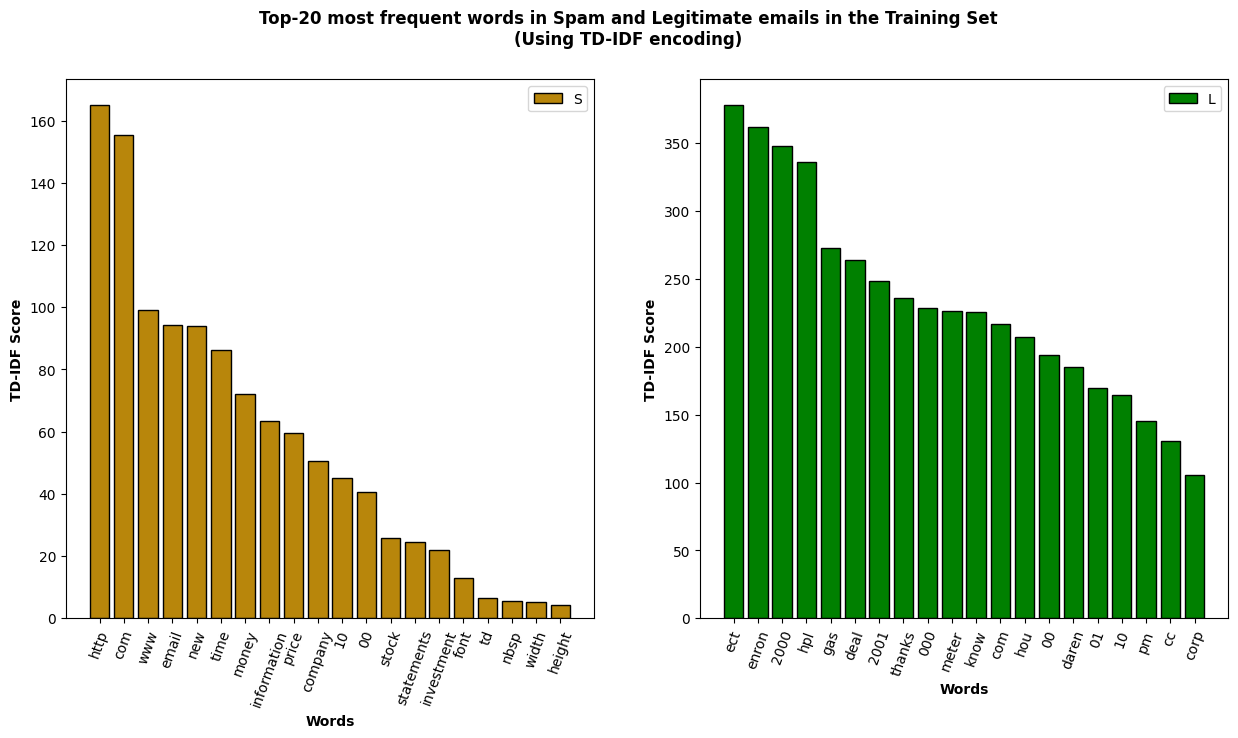

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Create separate Tf-Id vectorizers for spam and legitimate emails; restricting the resultant matrices to top 20 features
spam_tf_id_vectorizer = TfidfVectorizer(max_features=20,max_df=0.5,stop_words='english') #Stop-word removal, Ignoring common words that appear in more than 50% of documents
legit_tf_id_vectorizer = TfidfVectorizer(max_features=20,max_df=0.5,stop_words='english')

#Create feature matrices using both spam and legitimate email's content
spam_tf_features = spam_tf_id_vectorizer.fit_transform(raw_documents=spam_contents)
legit_tf_features = legit_tf_id_vectorizer.fit_transform(raw_documents=legitimate_contents)

#Convert the matrices into easily accessible arrays
spam_array = spam_tf_features.toarray()
legit_array = legit_tf_features.toarray()

#Access the words and their respective frequencies from the feature matrix
spam_words = spam_tf_id_vectorizer.get_feature_names_out().tolist()
legit_words = legit_tf_id_vectorizer.get_feature_names_out().tolist()
spam_words_frequency = np.sum(spam_array,axis=0)
legit_words_frequency = np.sum(legit_array,axis=0)

#Create dataframes for both spam and legitimate words with their respective TD-IDF score in descending order
spam_df = pd.DataFrame({'word':spam_words,'score':spam_words_frequency}).sort_values(by='score',ascending=False)
legit_df = pd.DataFrame({'word':legit_words,'score':legit_words_frequency}).sort_values(by='score',ascending=False)

fig, axs = plt.subplots(1,2,figsize=(15,7))

#Create a bar plot for the spam words and set the plot details
axs[0].bar(spam_df['word'],spam_df['score'],color='darkgoldenrod',edgecolor='black')
axs[0].set_xlabel('Words',fontweight='bold')
axs[0].set_ylabel('TD-IDF Score',fontweight='bold')
axs[0].tick_params(axis='x',rotation=70)
axs[0].legend('Spam')

#Create a bar plot for the legitimate words and set the plot details
axs[1].bar(legit_df['word'],legit_df['score'],color='green',edgecolor='black')
axs[1].set_xlabel('Words',fontweight='bold')
axs[1].set_ylabel('TD-IDF Score',fontweight='bold')
axs[1].tick_params(axis='x',rotation=70)
axs[1].legend('Legit')

#Set a commom title for both the plots and display the subplots
fig.suptitle('Top-20 most frequent words in Spam and Legitimate emails in the Training Set\n(Using TD-IDF encoding)',fontweight='bold')
plt.show()


As we can clearly interpret after comparing graph plots of both the techniques, the graph plot for TD-IDF encoding gives a different result as it is better at handling the stop-words and common-terms that may not be informative for classification. 
It assigns a weight to each word based on its frequency in the document and its rarity in the corpus.
Hence, in the graph plot we can see that the ranking for most frequent words have changed for several terms.
This will help us later in choosing the right classification model.
Next, we compare the distribution of email lengths in spam and non-spam emails using a Boxplot.

Spam emails length(Top 30): [21749, 11932, 11318, 11169, 9905, 9842, 9494, 9491, 9487, 9304, 9011, 8960, 8834, 8790, 8643, 8150, 8140, 8031, 8019, 8008, 7730, 7662, 7542, 7489, 7461, 7176, 7112, 6992, 6949, 6947]
Legitimate emails length(Top 30): [31860, 16061, 15999, 13178, 13170, 12830, 11585, 10515, 9471, 9451, 8951, 8176, 7512, 7471, 7356, 7349, 7196, 7170, 7139, 6850, 6447, 6321, 6276, 6248, 6051, 6024, 5963, 5938, 5777, 5700]


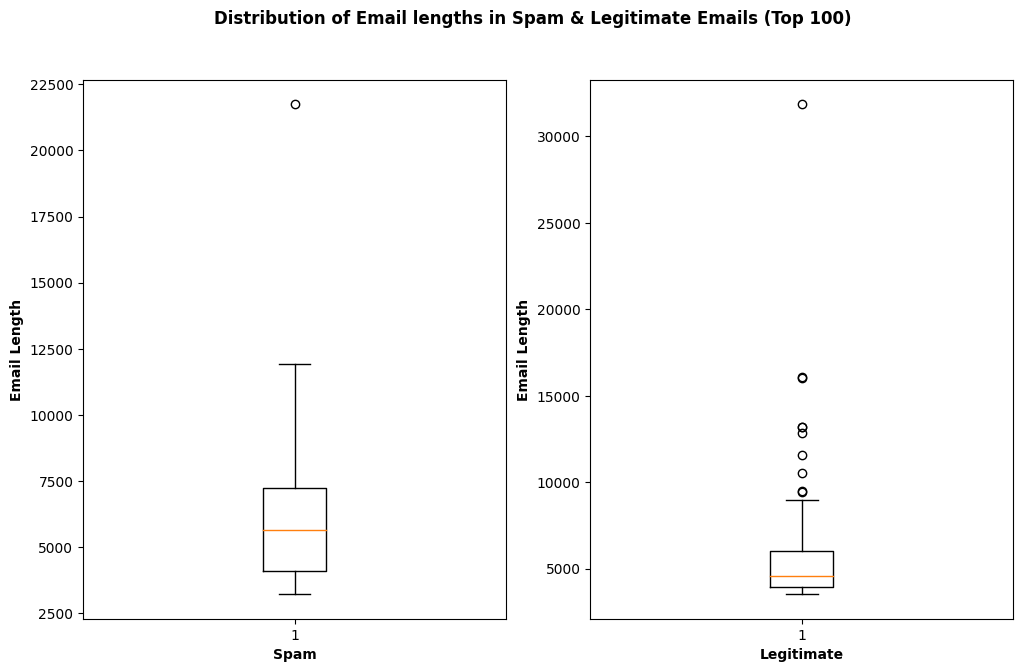

In [70]:
spam_email_length = []
legit_email_length = []
for fname in os.listdir(train_set_dir):
    fpath = os.path.join(train_set_dir,fname)
    with open(fpath,'r',encoding='latin1') as f:
        content = f.read()  #Read the contents of each file
        if(fname.__contains__('.spam')):
            spam_email_length.append(len(content))
        else:
            legit_email_length.append(len(content))
spam_email_length.sort(reverse=True)   #Sort the email lengths in descending order; so we have the longest emails at the top
legit_email_length.sort(reverse=True)
print("Spam emails length(Top 30):",spam_email_length[0:30])    #Print the lengths of the top-30 longest spam and legitimate emails
print("Legitimate emails length(Top 30):",legit_email_length[0:30])            

#Create a boxplot for the lengths of spam emails using the top-100 emails from the list
fig, ax = plt.subplots(1,2,figsize=(12,7))
ax[0].boxplot(spam_email_length[0:100])
ax[0].set_xlabel('Spam',fontweight='bold')
ax[0].set_ylabel('Email Length',fontweight='bold')

#Create a boxplot for the lengths of legitimate emails using the top-100 emails from the list
ax[1].boxplot(legit_email_length[0:100])
ax[1].set_xlabel('Legitimate',fontweight='bold')
ax[1].set_ylabel('Email Length',fontweight='bold')

fig.suptitle('Distribution of Email lengths in Spam & Legitimate Emails (Top 100)',fontweight='bold')
plt.show()

First, if we look at the printed values of lengths for the top-30 longest spam and legitimate emails, we can observe that just after the top-12 values there's a significant decline in the lengths of the legitimate emails whereas spam emails have a constant and fairly high content length.
Now looking at the distributions in the boxplot we can interpret that the data for spam emails is fairly more positively skewed in comparison to the legitimate email distribution. 
This means that the data spread for email lengths of spam emails is more towards the higher values.
The legitimate email distribution has significant amount of more outliers than spam emails. These data points may represent the emails that may contain genuine conversation or dealing between two parties. This is why they don't fall in the distribution of lower values.

We can say that the spam-emails are usually longer and the two data outliers in its distribution may represent the long emails used by spammers to trick the users and evade spam-filters.
Long spam emails may contain a lot of irrelevant content to decieve spam filters. It's a technique called "content spinning" to create versions of the same message. Long spam emails are an attempt to disguise as legitimate emails.

Next, we try and choose an appropriate supervised classification model and record the accuracy of each model that we test.

MultinomialNB : 0.938121546961326
LogisticRegression : 0.9685082872928177
LinearSVC : 0.9812154696132597


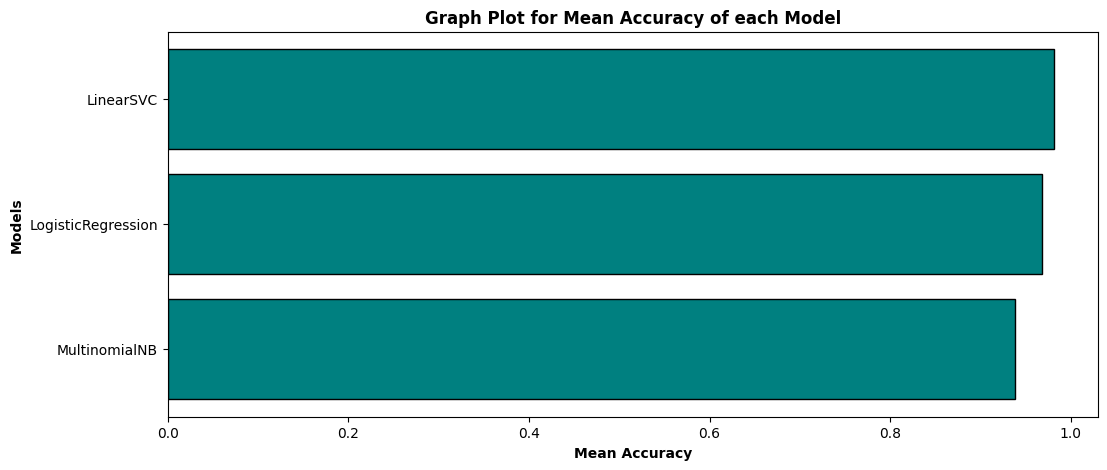

Best Model: LinearSVC with mean accuracy of 0.98


In [71]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

#Add the contents and labels of each email in the training set in separate lists and also store the length of the email in another list
emails = []
labels = []
email_length = []
for fname in os.listdir(train_set_dir):
    fpath = os.path.join(train_set_dir,fname)
    with open(fpath,'r',encoding='latin1') as f:
        content = f.read()
        if fname.__contains__('.spam'):
            labels.append('spam')
        else:
            labels.append('legitimate')
        emails.append(content)
        email_length.append(len(content))

#Create a Tf-Id vectorizer with stop-word removal, infrequent word removal, ignoring common words that appear in more than 50% of documents
vectorizer = TfidfVectorizer(max_df=0.5,min_df=5,stop_words='english')

features = vectorizer.fit_transform(raw_documents=emails)
features = np.concatenate([features.toarray(),np.array(email_length).reshape(-1,1)],axis=1) #Add the corresponding email lengths as a column to the feature matrix 

#Create a list of all the candidate classification models required to test
models = [
    ('MultinomialNB',MultinomialNB()),
    ('LogisticRegression',LogisticRegression(max_iter=2000)),
    ('LinearSVC',LinearSVC(dual=False))
]

#Evaluate each model using 10-fold cross-validation and record the mean accuracy
model_scores = []
for name,model in models:
    score = cross_val_score(model,features,labels,cv=10)
    mean_score = score.mean()
    model_scores.append((name,mean_score))

#Print the mean accuracy for each model
for name,score in model_scores:
    print(name,':',score)     

#Plot the mean accuracy for each model
plt.figure(figsize=(12,5))
plt.barh([name for name,score in model_scores],[score for name,score in model_scores],edgecolor='black',color='teal')
plt.xlabel('Mean Accuracy',fontweight='bold')
plt.ylabel('Models',fontweight='bold')
plt.title('Graph Plot for Mean Accuracy of each Model',fontweight='bold')
plt.show()

#Select and retain the best model based on the mean accuracy
best_model_name, best_model_score = max(model_scores, key=lambda x: x[1])
best_model = [model for name, model in models if name == best_model_name][0]
print('Best Model:',best_model_name,'with mean accuracy of',round(best_model_score,2))

We use TD-IDF encoding for feature extraction and also use email lengths as one of the feature along with the feature matrix to make the test more precised and efficient.
As we can clearly see from the graph, LinearSVC seems to be the best fit for the supervised classification model that we can use for our spam detection test.
It has the highest mean accuracy amongst all the models that we cross validated.

At last, we evaluate the model that we selected and test it for classification with the emails in our test dataset.
We record its performance metrics as well and compute the accuracy of the model against the test set.

Accuracy Score: 0.9819587628865979
Precision Score: 0.9971988795518207
Recall Score: 0.9771271729185728
F1 Score: 0.9870609981515712
Confusion Matrix:
[[1068   25]
 [   3  456]]
True Positive Value: 1068
False Positive Value: 25
False Negative Value: 3
True Negative Value: 456


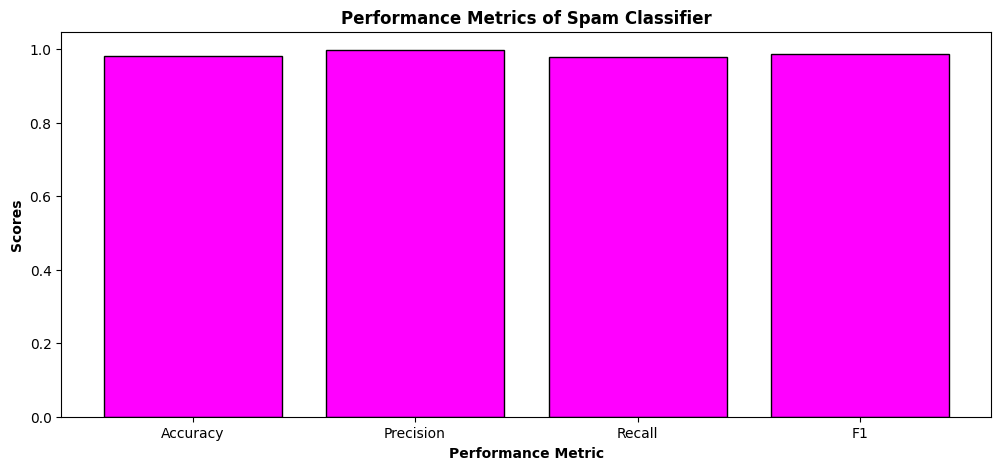

In [72]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix

test_emails = []
test_labels = []
test_email_length = []
for fname in os.listdir(test_set_dir):
    fpath = os.path.join(test_set_dir,fname)
    with open(fpath,'r',encoding='latin1') as f:
        content = f.read()
        if fname.__contains__('.spam'):
            test_labels.append('spam')
        else:
            test_labels.append('legitimate')    
        test_emails.append(content)
        test_email_length.append(len(content))

best_model.fit(features,labels)   #Fit the chosen model on the training set
test_features = vectorizer.transform(raw_documents=test_emails) #Transform the test emails to feature vectors
test_features = np.concatenate([test_features.toarray(),np.array(test_email_length).reshape(-1,1)],axis=1) #Add the email lengths as a feature
prediction = best_model.predict(test_features) #We use the predict method for spam classification

#Compute the performance metrics of the model
accuracy = accuracy_score(test_labels,prediction)
precision = precision_score(test_labels,prediction,pos_label='legitimate')
recall = recall_score(test_labels,prediction,pos_label='legitimate')
f1 = f1_score(test_labels,prediction,pos_label='legitimate')
matrix = confusion_matrix(test_labels,prediction)

#Print the performance metrics and the confusion matrix along with TP,FP,TN,FN values from it
print(f'Accuracy Score: {accuracy}')
print(f'Precision Score: {precision}')
print(f'Recall Score: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{matrix}')
print(f'True Positive Value: {matrix[0][0]}')
print(f'False Positive Value: {matrix[0][1]}')
print(f'False Negative Value: {matrix[1][0]}')
print(f'True Negative Value: {matrix[1][1]}')

#Define the names and values of the performance metrics
metric_names = ['Accuracy','Precision','Recall','F1']
metric_values = [accuracy,precision,recall,f1]

#Create a bar chart of the performance metrics
plt.figure(figsize=(12,5))
plt.bar(metric_names,metric_values,edgecolor='black',color='magenta')
plt.xlabel('Performance Metric',fontweight='bold')
plt.ylabel('Scores',fontweight='bold')
plt.title('Performance Metrics of Spam Classifier',fontweight='bold')
plt.show()

The supervised classification model that we chose, i.e. LinearSVC had a very high performance and accuracy against the test dataset.
It suggests that the model is able to generalize well to the new data and may be useful in a real production classifier.